In [3]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

# Download MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

/Users/KDV/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Code for visualization
def visualize_row(images, img_width=28, cmap='gray'):
    im = np.reshape(images, [-1, img_width])
    plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=cmap)
    plt.show()

In [10]:
tf.reset_default_graph() # if need to re-run cell, don't add new nodes to the tensor graph

epsilon_dim = 100 # number of random numbers given to generator
img_dim = 28*28
g_hidden_dim = 256
d_hidden_dim = 256

def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.)) # Xavier initialization is Var(W) = 1/n_in with gaussian distribution

# making G's variables
weights = {
    'g_hidden': tf.Variable(glorot_init([epsilon_dim,g_hidden_dim])),
    'g_out': tf.Variable(glorot_init([g_hidden_dim,img_dim])),
    
    'd_hidden': tf.Variable(glorot_init([img_dim,d_hidden_dim])),
    'd_out': tf.Variable(glorot_init([d_hidden_dim,1]))
}

biases = {
    'g_hidden': tf.Variable(tf.zeros([g_hidden_dim])),
    'g_out': tf.Variable(tf.zeros([img_dim])),
    
    'd_hidden': tf.Variable(tf.zeros([d_hidden_dim])),
    'd_out': tf.Variable(tf.zeros([1]))
}

# generator
def generator(x):
    hidden_layer = tf.nn.relu(tf.matmul(x,weights['g_hidden']) + biases['g_hidden'])
    out_layer = tf.sigmoid(tf.matmul(hidden_layer,weights['g_out']) + biases['g_out'])
    return out_layer

# discriminator
def discriminator(x):
    hidden_layer = tf.nn.relu(tf.matmul(x,weights['d_hidden']) + biases['d_hidden'])
    out_layer = tf.sigmoid(tf.matmul(hidden_layer,weights['d_out']) + biases['d_out'])
    return out_layer

# Build Networks

# network inputs
epsilon = tf.placeholder(tf.float32,[None, epsilon_dim], name='g_input')
d_input = tf.placeholder(tf.float32,[None, img_dim], name='d_input')

# building networks
g_samples = generator(epsilon) # generator network using epsilon
d_real = discriminator(d_input) # discriminator network using real images
d_fake = discriminator(g_samples) # discriminator network using fake images

# loss functions
loss_g = -tf.reduce_mean(tf.log(d_fake))
loss_d = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))

# Build Optimizers
learning_rate = 0.01
optimizer_g = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_g, var_list=[weights['g_hidden'], weights['g_out'], biases['g_hidden'], biases['g_out']])
optimizer_d = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss_d, var_list=[weights['g_hidden'], weights['g_out'], biases['g_hidden'], biases['g_out']])

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

num_steps = 70000
batch_size = 128

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, epsilon_dim])

    # Train
    feed_dict = {d_input: batch_x, epsilon: z}
    _, _, gl, dl = sess.run([optimizer_g, optimizer_d, loss_g, loss_d],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))

Step 1: Generator Loss: 0.965312, Discriminator Loss: 1.292956
Step 2000: Generator Loss: 0.959796, Discriminator Loss: 1.271968
Step 4000: Generator Loss: 0.957094, Discriminator Loss: 1.278381
Step 6000: Generator Loss: 0.951526, Discriminator Loss: 1.273984
Step 8000: Generator Loss: 0.958663, Discriminator Loss: 1.266754
Step 10000: Generator Loss: 0.952363, Discriminator Loss: 1.276183
Step 12000: Generator Loss: 0.954674, Discriminator Loss: 1.281653
Step 14000: Generator Loss: 0.953639, Discriminator Loss: 1.292235
Step 16000: Generator Loss: 0.953869, Discriminator Loss: 1.302920
Step 18000: Generator Loss: 0.955756, Discriminator Loss: 1.285611
Step 20000: Generator Loss: 0.955829, Discriminator Loss: 1.273747
Step 22000: Generator Loss: 0.957083, Discriminator Loss: 1.263497
Step 24000: Generator Loss: 0.950248, Discriminator Loss: 1.276615
Step 26000: Generator Loss: 0.951223, Discriminator Loss: 1.282552
Step 28000: Generator Loss: 0.945757, Discriminator Loss: 1.280298
Ste

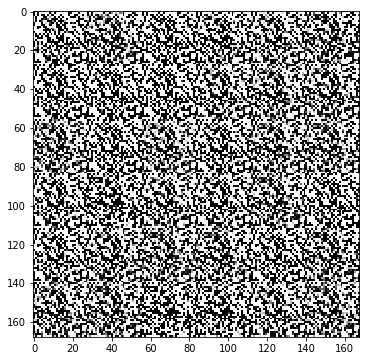

In [12]:
# Testing
# Generate images from noise, using the generator network.
n = 6
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[n, epsilon_dim])
    # Generate image from noise.
    g = sess.run(g_samples, feed_dict={epsilon: z})
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()